In [35]:
# %% Imports & Config
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Optional: SciPy for Mann–Whitney U
try:
    from scipy.stats import mannwhitneyu
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    precision_recall_curve, f1_score
)

In [36]:
# Paths
BASE_DIR  = Path(r"D:\FLY114")
XLSX_PATH = BASE_DIR / "Diagnosis and autonomic marker data for VNS research_20250813.xlsx"
OUT_DIR   = BASE_DIR / "Data"
PLOTS_DIR = OUT_DIR / "eda_plots"
OUT_XLSX  = OUT_DIR / "analysis_summary.xlsx"
OVR_TXT   = OUT_DIR / "ovr_classification_report.txt"
OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

SHEET_NAME = "Sheet1"

# Columns
BASIC_COLS   = ["Age", "Sex", "BMI"]
LABEL_COLS   = ["SSD", "MDD", "Panic", "GAD"]
CONTROL_COLS = ["DM", "TCA", "MARTA"]
HRV_COLS     = ["SDNN", "LF", "HF", "LFHF", "SC", "FT", "RSA"]
ALL_FEATURES = BASIC_COLS + CONTROL_COLS + HRV_COLS

SCALE_MAP = {
    "Sex":"Nominal", "SSD":"Nominal", "MDD":"Nominal", "Panic":"Nominal", "GAD":"Nominal",
    "DM":"Nominal", "TCA":"Nominal", "MARTA":"Nominal",
    "Age":"Ratio", "BMI":"Ratio", "SDNN":"Ratio", "LF":"Ratio", "HF":"Ratio",
    "LFHF":"Ratio", "SC":"Ratio", "FT":"Interval", "RSA":"Ratio"
}

In [37]:
# %% Load Excel & Preview
df = pd.read_excel(XLSX_PATH, sheet_name=SHEET_NAME)
df.columns = [c.strip() for c in df.columns]
print("Shape:", df.shape)
display(df.head(10))

Shape: (502, 17)


,Age,Sex,BMI,SSD,MDD,Panic,GAD,DM,TCA,MARTA,SDNN,LF,HF,LFHF,SC,FT,RSA
0,45,0,21.359306,1,0,0,1,0,0,0,55.16,90.04,132.76,0.68,0.21,25.90,7.86
1,42,0,26.171875,1,1,0,0,0,0,0,15.40,6.40,2.90,2.21,0.99,34.26,2.27
2,29,0,30.483380,1,1,1,1,0,0,0,62.88,128.44,196.70,0.65,0.57,33.60,7.87
3,22,1,28.405504,1,1,1,1,0,0,1,19.98,24.88,14.16,1.76,0.17,34.27,3.82
4,29,0,20.957170,1,1,0,1,0,0,0,12.34,4.67,2.93,1.59,0.61,34.56,3.83
5,31,0,18.106140,1,1,1,0,0,0,0,112.97,529.23,495.21,1.07,0.16,26.46,13.52
6,41,0,20.446741,1,1,0,1,0,0,0,37.93,42.63,93.94,0.45,0.20,27.10,5.12
7,52,1,20.549887,1,0,0,0,0,0,0,31.02,33.72,9.76,3.46,0.20,32.45,4.65
8,27,1,19.753086,0,1,0,0,0,1,0,26.03,48.13,34.65,1.39,0.16,26.21,6.76
9,44,1,31.377989,1,0,0,0,0,0,0,83.54,164.35,443.70,0.37,0.90,32.86,8.33


In [38]:
# %% Type Casting & Cleaning
for c in [*ALL_FEATURES, *LABEL_COLS]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# normalize Sex if string (M/F -> 1/0)
if "Sex" in df.columns and df["Sex"].dtype == object:
    norm = df["Sex"].astype(str).str.lower().str[0].map({"m":1, "f":0})
    if norm.notna().mean() > 0.6:
        df["Sex"] = norm

# LFHF should be >= 0
if "LFHF" in df.columns:
    df.loc[df["LFHF"] < 0, "LFHF"] = np.nan

display(df.describe(include="all").T)

,count,mean,std,min,25%,50%,75%,max
Age,502.0,44.537849,12.848944,20.000000,35.000000,44.00000,54.000000,75.000000
Sex,502.0,0.388446,0.487883,0.000000,0.000000,0.00000,1.000000,1.000000
BMI,502.0,23.804120,4.296999,15.173038,20.825991,23.08173,26.068603,45.440876
SSD,502.0,0.247012,0.431704,0.000000,0.000000,0.00000,0.000000,1.000000
MDD,502.0,0.199203,0.399800,0.000000,0.000000,0.00000,0.000000,1.000000
Panic,502.0,0.091633,0.288796,0.000000,0.000000,0.00000,0.000000,1.000000
GAD,502.0,0.324701,0.468730,0.000000,0.000000,0.00000,1.000000,1.000000
DM,502.0,0.061753,0.240946,0.000000,0.000000,0.00000,0.000000,1.000000
TCA,502.0,0.015936,0.125354,0.000000,0.000000,0.00000,0.000000,1.000000
MARTA,502.0,0.027888,0.164817,0.000000,0.000000,0.00000,0.000000,1.000000


In [39]:
# %% Missing Report
cols_to_check = [c for c in [*ALL_FEATURES, *LABEL_COLS] if c in df.columns]
missing = df[cols_to_check].isna().sum().to_frame("missing_count")
missing["missing_ratio"] = (missing["missing_count"]/len(df)).round(4)
display(missing.sort_values("missing_count", ascending=False))

,missing_count,missing_ratio
Age,0,0.0
Sex,0,0.0
BMI,0,0.0
DM,0,0.0
TCA,0,0.0
MARTA,0,0.0
SDNN,0,0.0
LF,0,0.0
HF,0,0.0
LFHF,0,0.0


In [40]:
# %% Diagnosis Distribution (0/1)
diag_dist = (
    pd.DataFrame({col: df[col].value_counts(dropna=False) for col in LABEL_COLS if col in df.columns})
    .fillna(0).astype(int).T
)
diag_dist.columns = [f"value_{c}" for c in diag_dist.columns]
display(diag_dist)

,value_0,value_1
SSD,378,124
MDD,402,100
Panic,456,46
GAD,339,163


In [41]:
# %% Descriptive Stats (Features)
desc = df[[c for c in ALL_FEATURES if c in df.columns]].describe().T
display(desc)

,count,mean,std,min,25%,50%,75%,max
Age,502.0,44.537849,12.848944,20.000000,35.000000,44.00000,54.000000,75.000000
Sex,502.0,0.388446,0.487883,0.000000,0.000000,0.00000,1.000000,1.000000
BMI,502.0,23.804120,4.296999,15.173038,20.825991,23.08173,26.068603,45.440876
DM,502.0,0.061753,0.240946,0.000000,0.000000,0.00000,0.000000,1.000000
TCA,502.0,0.015936,0.125354,0.000000,0.000000,0.00000,0.000000,1.000000
MARTA,502.0,0.027888,0.164817,0.000000,0.000000,0.00000,0.000000,1.000000
SDNN,502.0,69.530179,69.117263,7.980000,31.012500,47.65500,75.202500,510.760000
LF,502.0,463.685558,1616.836921,0.730000,28.825000,71.63500,242.950000,23979.420000
HF,502.0,453.254920,1137.022102,0.270000,33.035000,96.39500,278.210000,12385.790000
LFHF,502.0,1.456076,1.992652,0.070000,0.480000,0.77000,1.540000,20.140000


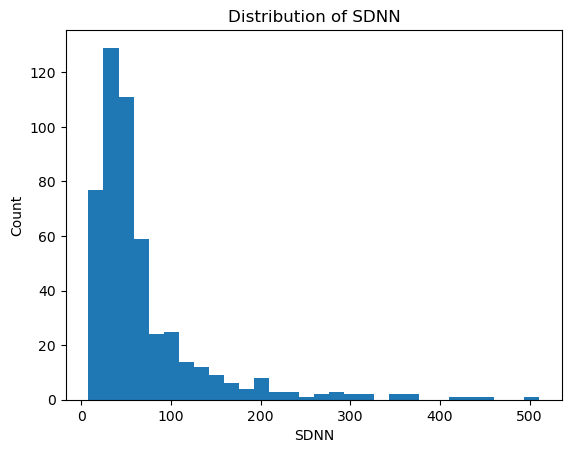

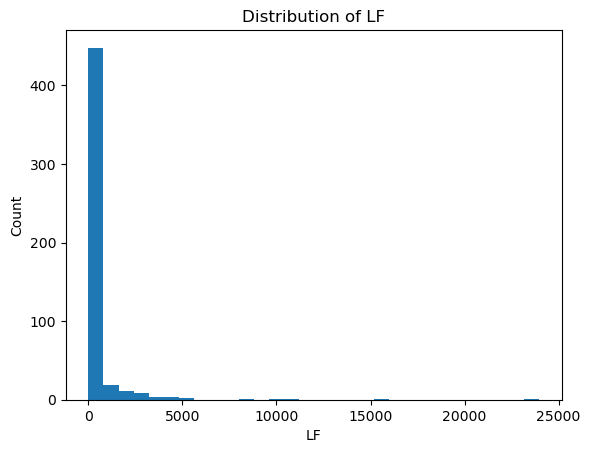

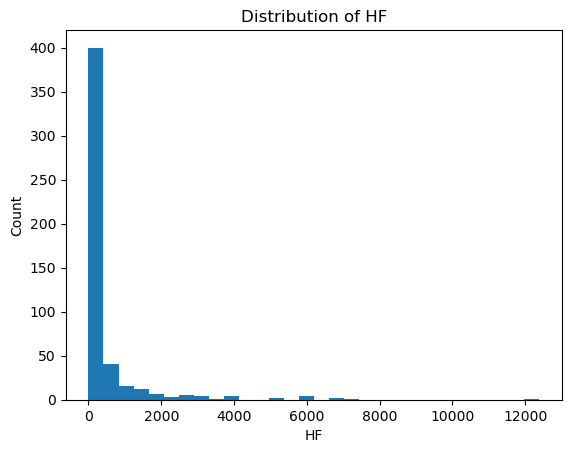

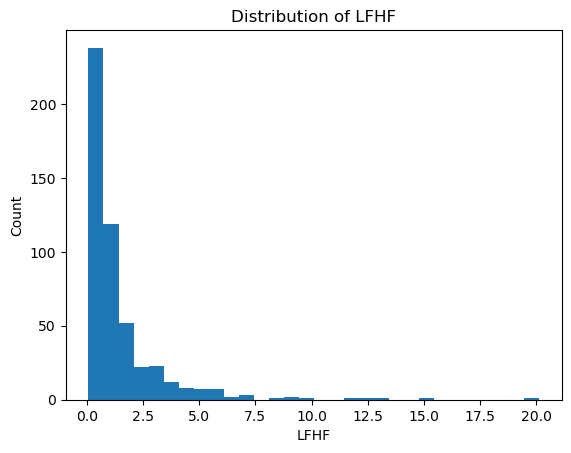

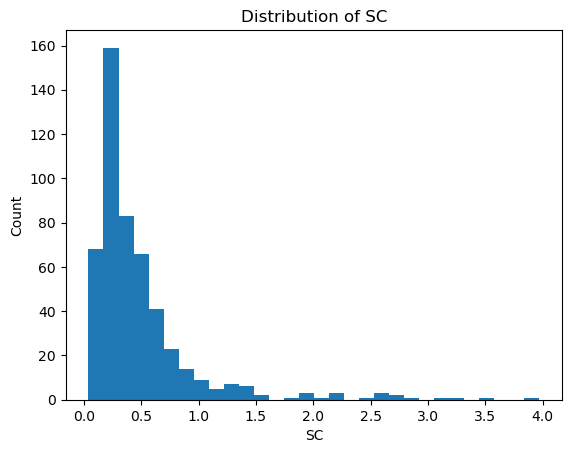

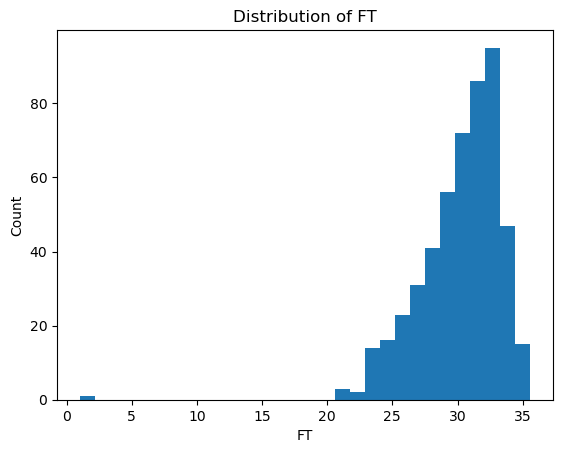

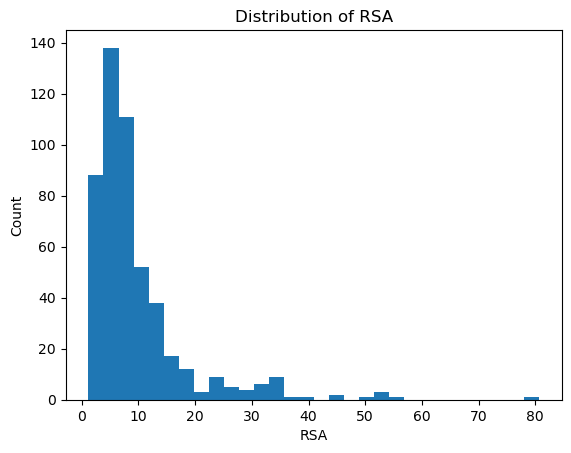

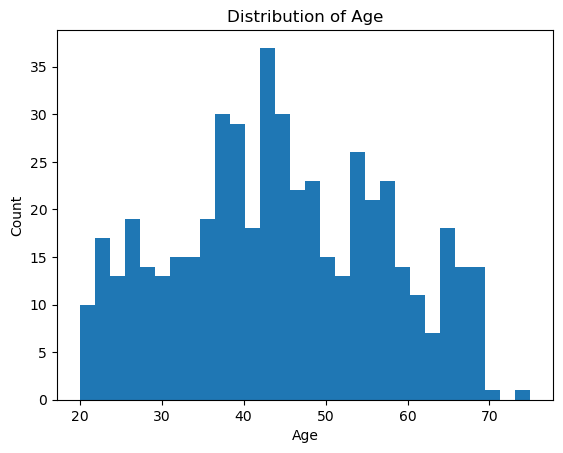

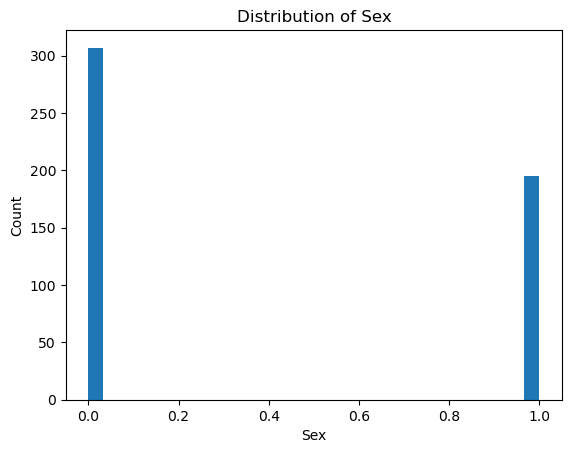

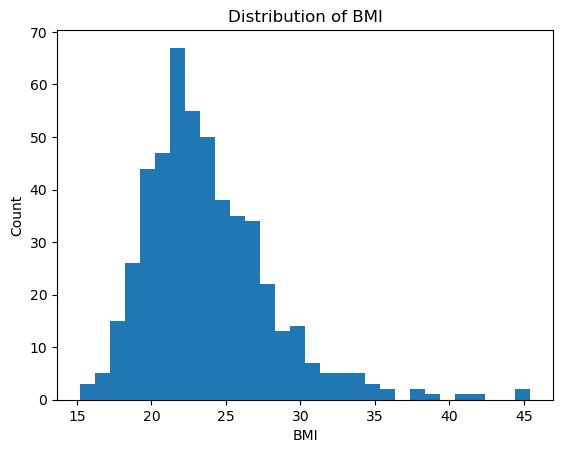

In [42]:
# %% Histograms
for col in [c for c in HRV_COLS + BASIC_COLS if c in df.columns]:
    s = df[col].dropna()
    if len(s) == 0:
        continue
    plt.figure()
    plt.hist(s, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.savefig(PLOTS_DIR / f"hist_{col}.png", bbox_inches="tight")
    plt.show()

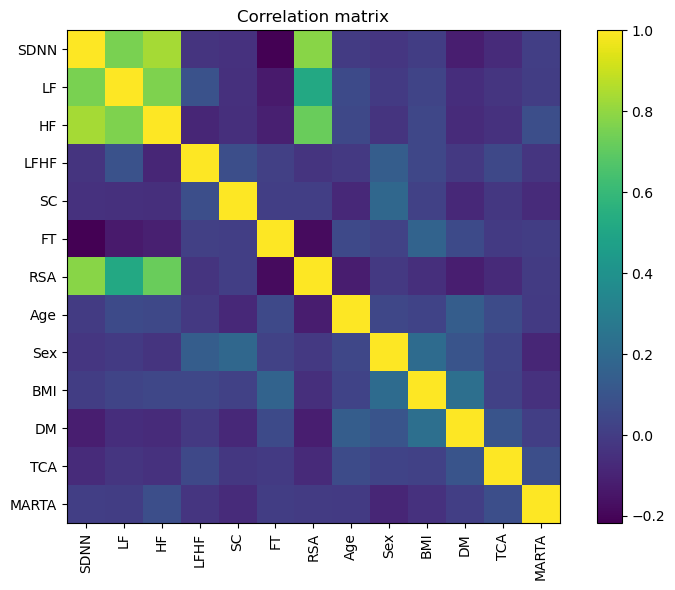

,SDNN,LF,HF,LFHF,SC,FT,RSA,Age,Sex,BMI,DM,TCA,MARTA
SDNN,1.000000,0.757331,0.836192,-0.033155,-0.045712,-0.217385,0.781929,-0.008077,-0.024663,0.002340,-0.114307,-0.069740,0.008519
LF,0.757331,1.000000,0.762507,0.088316,-0.046478,-0.129727,0.518707,0.056335,-0.011018,0.032805,-0.055877,-0.031608,0.005580
HF,0.836192,0.762507,1.000000,-0.086649,-0.051832,-0.112338,0.719662,0.047947,-0.035068,0.041320,-0.069285,-0.045972,0.075612
LFHF,-0.033155,0.088316,-0.086649,1.000000,0.074174,0.013671,-0.034803,-0.017197,0.142231,0.039842,-0.016207,0.044360,-0.031148
SC,-0.045712,-0.046478,-0.051832,0.074174,1.000000,0.008674,0.007487,-0.079295,0.187972,0.016689,-0.077277,-0.019257,-0.068054
FT,-0.217385,-0.129727,-0.112338,0.013671,0.008674,1.000000,-0.179494,0.050507,0.023460,0.169718,0.056157,-0.010238,0.004210
RSA,0.781929,0.518707,0.719662,-0.034803,0.007487,-0.179494,1.000000,-0.122067,-0.014940,-0.051332,-0.113098,-0.074311,-0.006770
Age,-0.008077,0.056335,0.047947,-0.017197,-0.079295,0.050507,-0.122067,1.000000,0.043341,0.025518,0.140761,0.061587,-0.012752
Sex,-0.024663,-0.011018,-0.035068,0.142231,0.187972,0.023460,-0.014940,0.043341,1.000000,0.209667,0.101167,0.029126,-0.085345
BMI,0.002340,0.032805,0.041320,0.039842,0.016689,0.169718,-0.051332,0.025518,0.209667,1.000000,0.228586,0.019762,-0.043895


In [43]:
# %% Correlation Matrix (Features)
corr_cols = [c for c in HRV_COLS + BASIC_COLS + CONTROL_COLS if c in df.columns]
corr = df[corr_cols].corr().fillna(0.0)
plt.figure(figsize=(8,6))
cax = plt.imshow(corr.values, interpolation='nearest')
plt.title("Correlation matrix")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.colorbar(cax)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "corr_matrix.png", bbox_inches="tight")
plt.show()
display(corr)

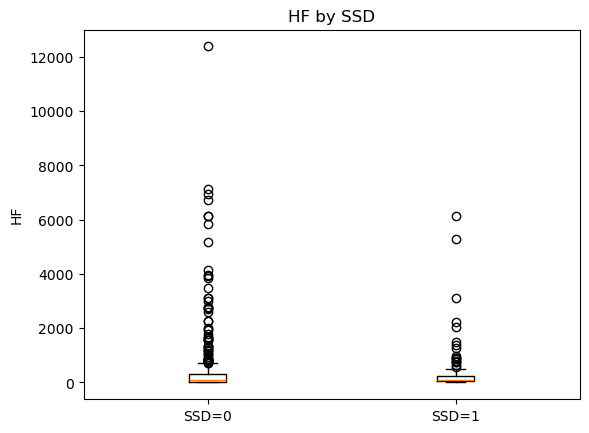

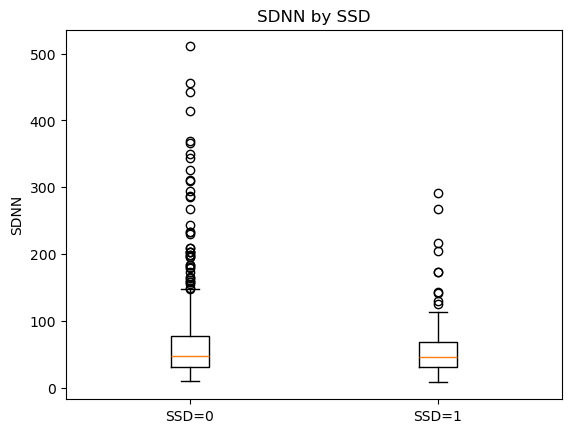

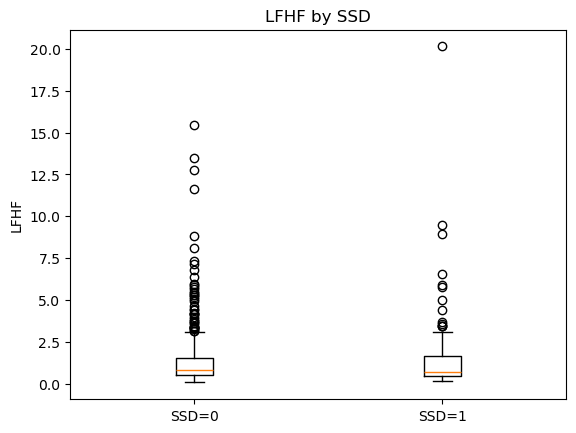

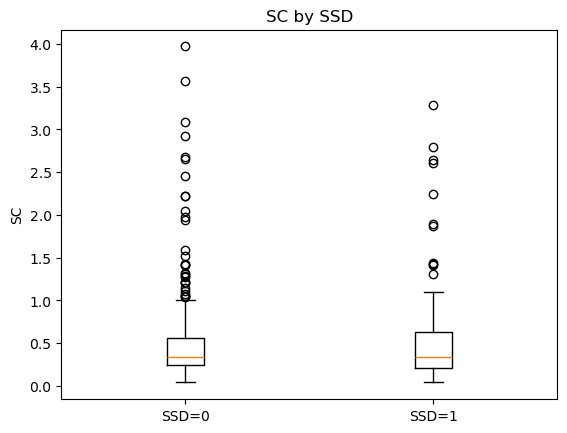

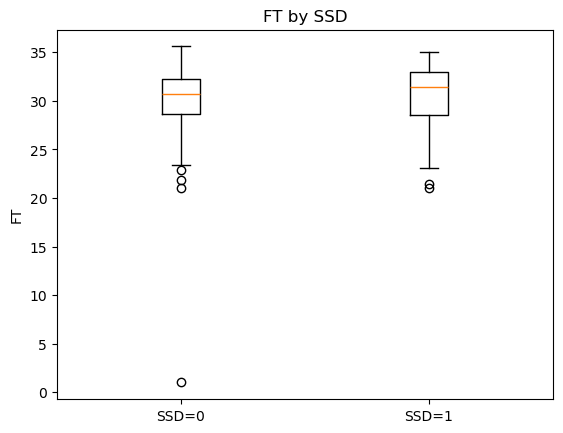

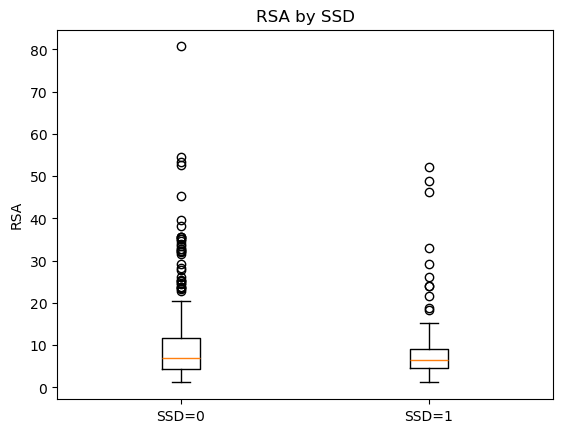

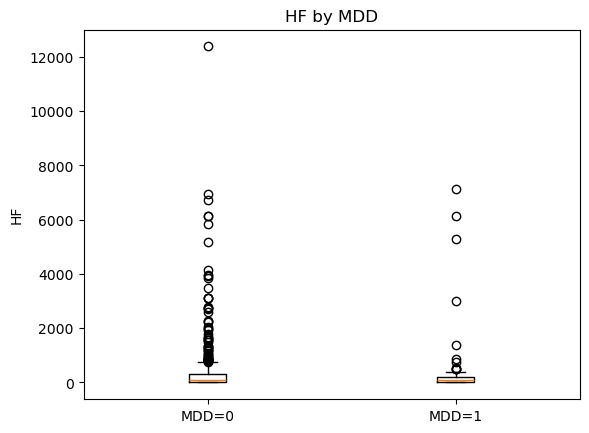

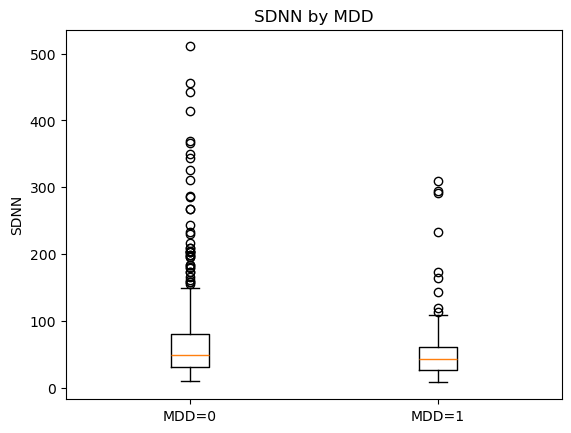

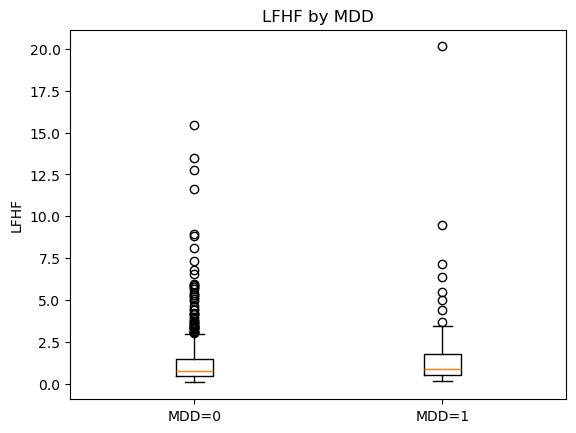

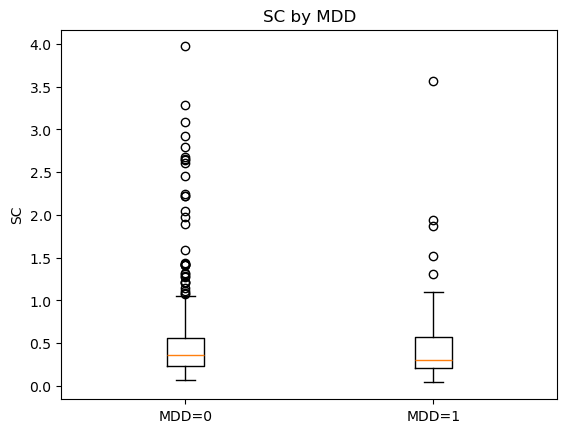

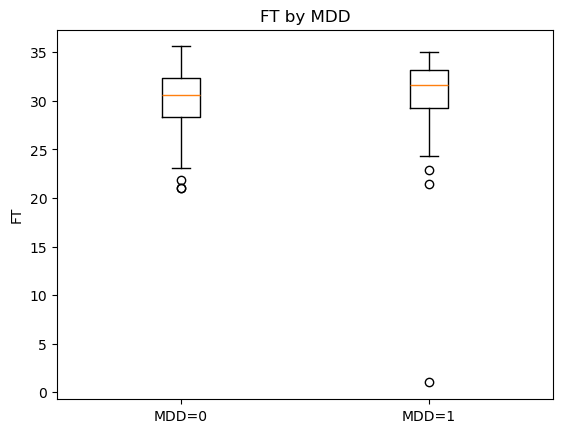

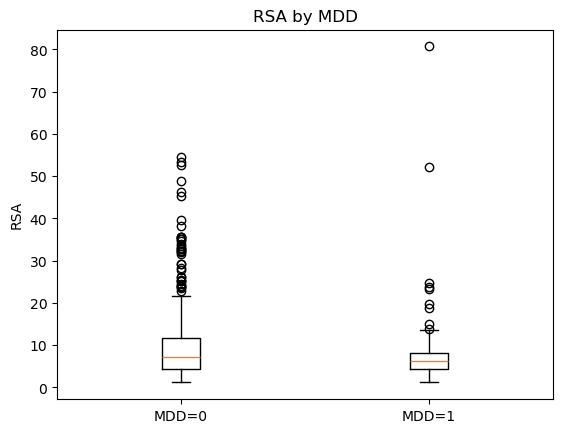

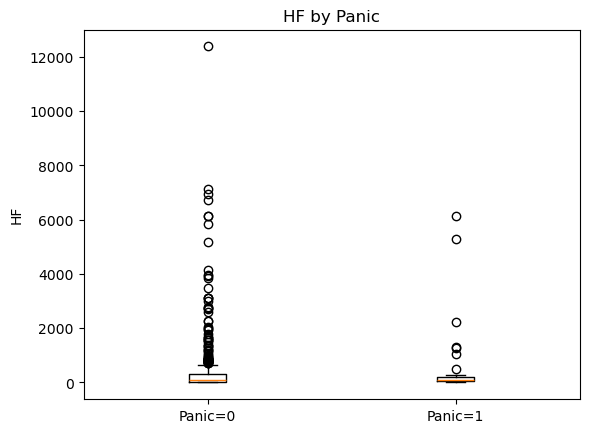

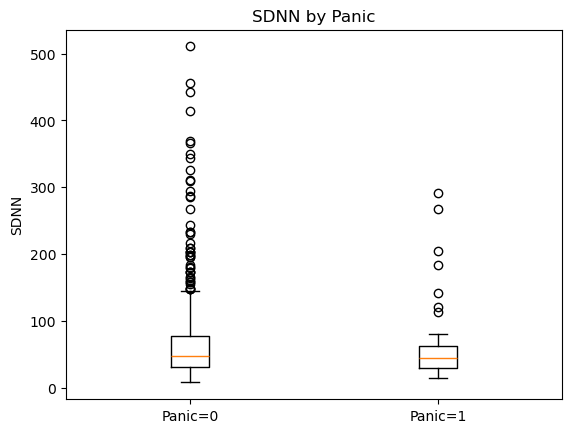

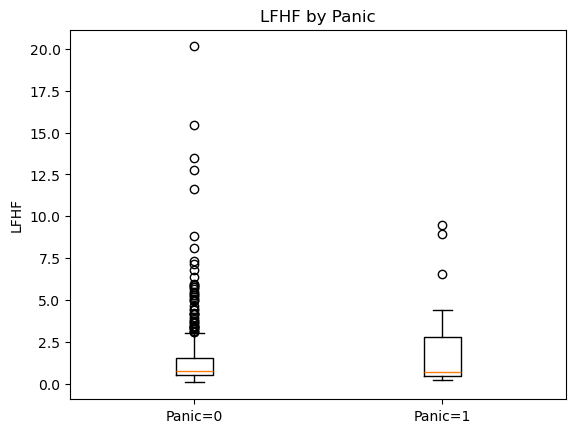

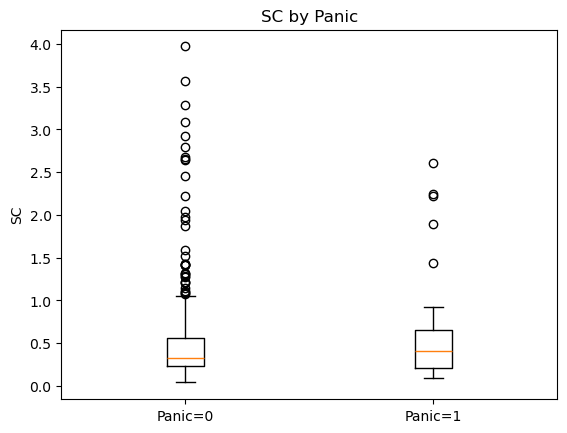

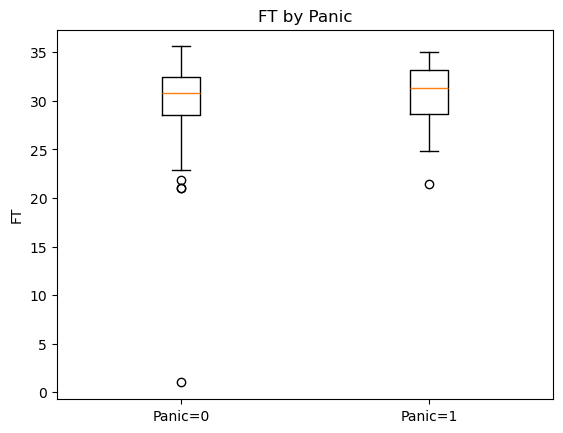

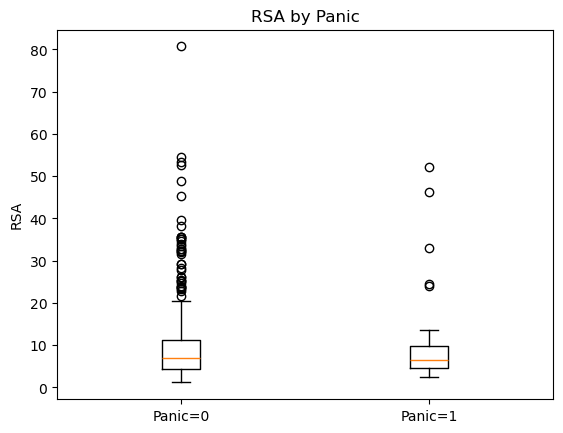

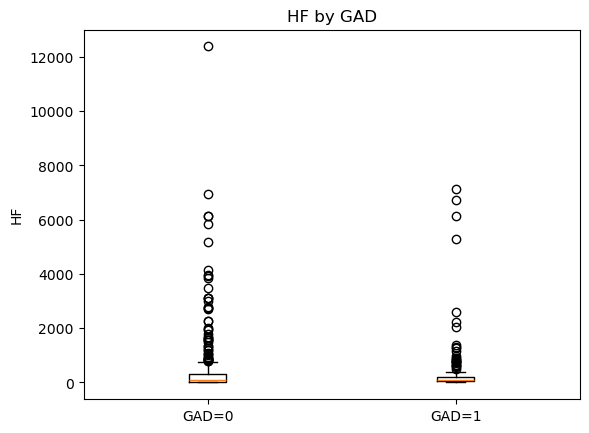

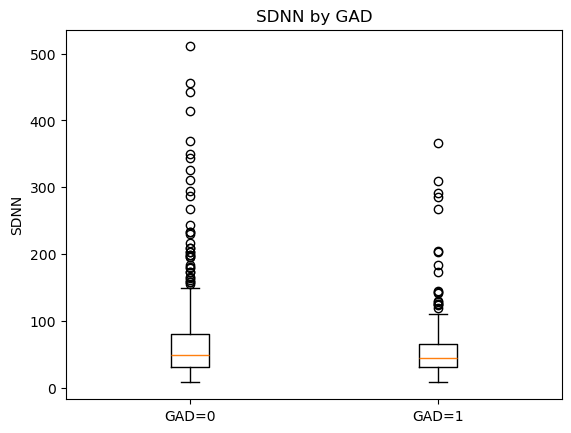

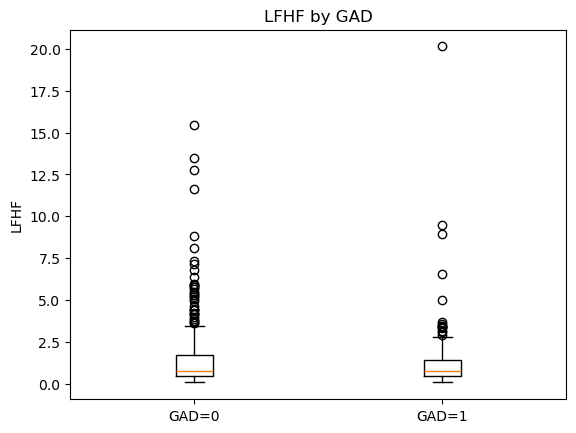

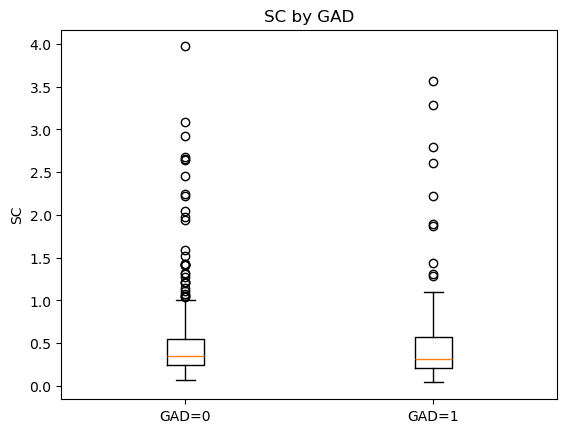

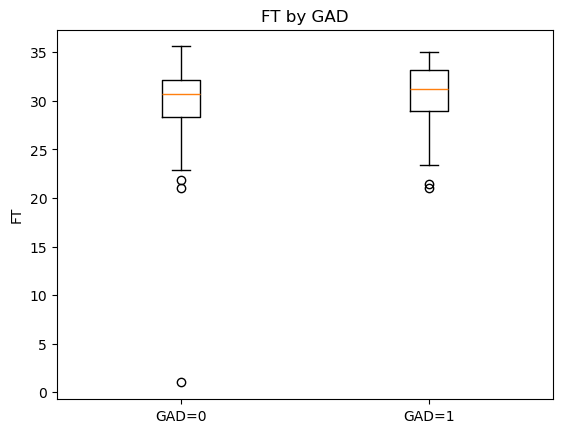

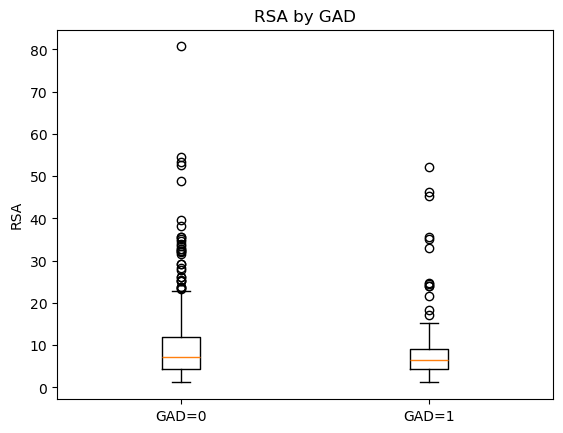

In [44]:
# %% Boxplots by Diagnosis
selected = [c for c in ["HF","SDNN","LFHF","SC","FT","RSA"] if c in df.columns]
for dx in [d for d in LABEL_COLS if d in df.columns]:
    for col in selected:
        a = df.loc[df[dx]==0, col].dropna()
        b = df.loc[df[dx]==1, col].dropna()
        if len(a)==0 and len(b)==0:
            continue
        plt.figure()
        plt.boxplot([a, b], labels=[f"{dx}=0", f"{dx}=1"])
        plt.title(f"{col} by {dx}")
        plt.ylabel(col)
        plt.savefig(PLOTS_DIR / f"box_{col}_by_{dx}.png", bbox_inches="tight")
        plt.show()

In [45]:
# %% Mann–Whitney U Tests (if SciPy available)
mw_rows = []
if SCIPY_OK:
    for dx in [d for d in LABEL_COLS if d in df.columns]:
        for f in [c for c in HRV_COLS if c in df.columns]:
            a = df.loc[df[dx]==0, f].dropna()
            b = df.loc[df[dx]==1, f].dropna()
            if len(a) > 5 and len(b) > 5:
                try:
                    stat, p = mannwhitneyu(a, b, alternative="two-sided")
                except Exception:
                    stat, p = (np.nan, np.nan)
            else:
                stat, p = (np.nan, np.nan)
            mw_rows.append({"diagnosis": dx, "feature": f, "n0": len(a), "n1": len(b), "mw_stat": stat, "p_value": p})
mw_df = pd.DataFrame(mw_rows) if mw_rows else pd.DataFrame(columns=["diagnosis","feature","n0","n1","mw_stat","p_value"])
display(mw_df.sort_values("p_value").head(30))

,diagnosis,feature,n0,n1,mw_stat,p_value
9,MDD,HF,402,100,23605.5,0.006932
12,MDD,FT,402,100,16663.0,0.008112
26,GAD,FT,339,163,23767.5,0.011192
7,MDD,SDNN,402,100,22989.0,0.026069
13,MDD,RSA,402,100,22923.5,0.029650
27,GAD,RSA,339,163,30318.5,0.077195
8,MDD,LF,402,100,22283.0,0.092703
10,MDD,LFHF,402,100,18132.5,0.129683
5,SSD,FT,378,124,21642.5,0.200833
22,GAD,LF,339,163,29494.0,0.220410


In [46]:
# %% PCA (HRV Features)
X = df[[c for c in HRV_COLS if c in df.columns]].replace([np.inf, -np.inf], np.nan).dropna()
if len(X) > 5:
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X.values)
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(Xs)
    pca_summary = pd.DataFrame({"component":["PC1","PC2"], "explained_variance_ratio": pca.explained_variance_ratio_})
    display(pca_summary)
else:
    print("Not enough rows for PCA")

,component,explained_variance_ratio
0,PC1,0.463609
1,PC2,0.154554


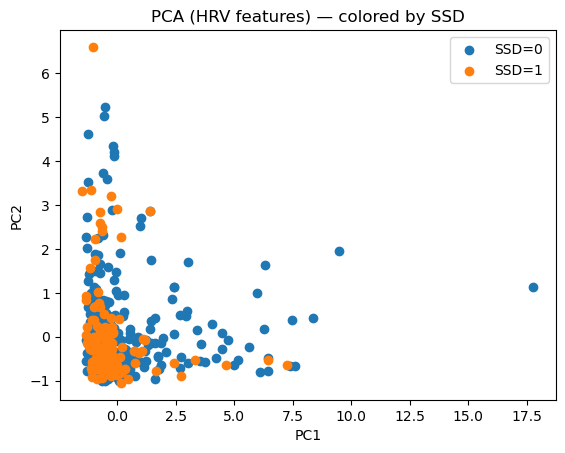

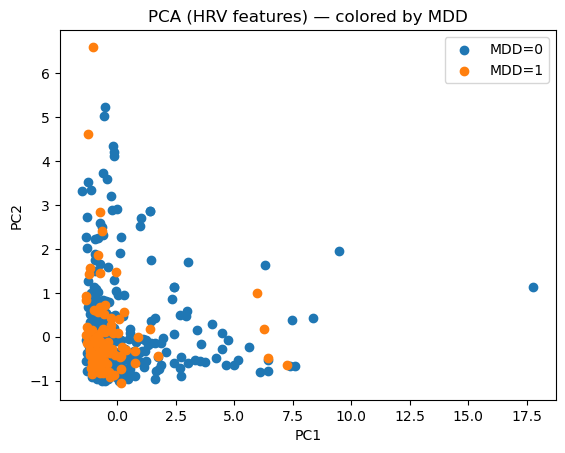

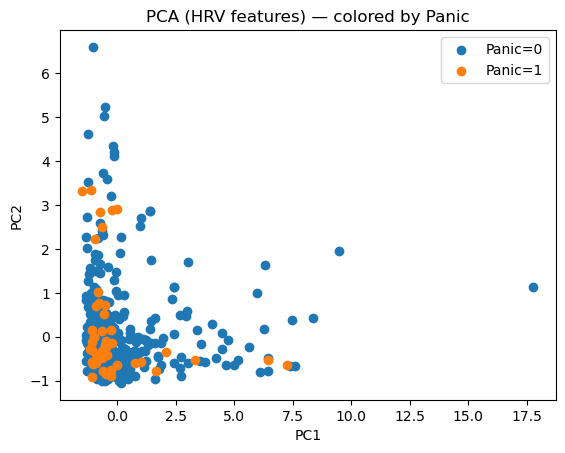

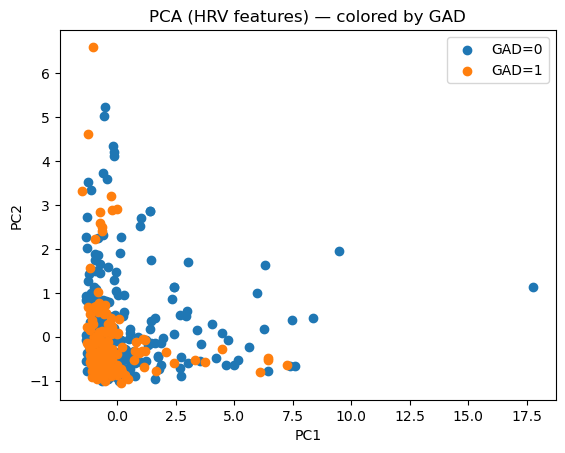

In [47]:
# %% PCA Scatter Colored by Diagnosis
if 'X2' in locals():
    idx = X.index
    for dx in [d for d in LABEL_COLS if d in df.columns]:
        ydx = df.loc[idx, dx]
        if ydx.notna().sum() == 0:
            continue
        plt.figure()
        mask0 = (ydx == 0)
        mask1 = (ydx == 1)
        plt.scatter(X2[mask0,0], X2[mask0,1], label=f"{dx}=0")
        plt.scatter(X2[mask1,0], X2[mask1,1], label=f"{dx}=1")
        plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
        plt.title(f"PCA (HRV features) — colored by {dx}")
        plt.savefig(PLOTS_DIR / f"pca_by_{dx}.png", bbox_inches="tight")
        plt.show()

In [48]:
# %% Binary Logistic Regression (5-fold ROC-AUC)
def binary_lr_auc(df_, target_col, feature_cols):
    data = df_[feature_cols + [target_col]].dropna()
    if target_col not in data or data[target_col].nunique() < 2 or len(data) < 30:
        return {"target": target_col, "n": len(data), "auc_cv_mean": np.nan, "auc_cv_std": np.nan, "note": "insufficient data"}
    X = data[feature_cols].values
    y = data[target_col].values.astype(int)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    model = LogisticRegression(max_iter=2000, solver="lbfgs", class_weight="balanced")  # balanced for imbalance
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = cross_val_score(model, Xs, y, cv=cv, scoring="roc_auc")
    return {"target": target_col, "n": len(data), "auc_cv_mean": float(np.mean(aucs)), "auc_cv_std": float(np.std(aucs)), "note": ""}

usable_feats = [c for c in ALL_FEATURES if c in df.columns]
ml_rows = []
for target in [t for t in LABEL_COLS if t in df.columns]:
    ml_rows.append(binary_lr_auc(df, target, usable_feats))
ml_df = pd.DataFrame(ml_rows)
display(ml_df)

,target,n,auc_cv_mean,auc_cv_std,note
0,SSD,502,0.612360,0.054828,
1,MDD,502,0.591167,0.043656,
2,Panic,502,0.510226,0.085985,
3,GAD,502,0.574354,0.011722,


In [49]:
# %% ----------- Multi-label OVR Logistic (random split + balancing) -------
# Helper: ensure the test set has at least a few positives/negatives per label
def robust_multilabel_split(n, test_size=0.2, min_pos=1, max_tries=100, seed=42):
    rng = np.random.RandomState(seed)
    n_test = int(n * test_size)
    idx = np.arange(n)
    for t in range(max_tries):
        rng.shuffle(idx)
        te = idx[:n_test]
        tr = idx[n_test:]
        yield tr, te  # caller will check label distribution and break

ovr_result = {}
sub = df[[*usable_feats, *[c for c in LABEL_COLS if c in df.columns]]].dropna()
if len(sub) >= 50 and all(c in sub.columns for c in LABEL_COLS):
    X = sub[usable_feats].values
    Y = sub[LABEL_COLS].values.astype(int)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # try random splits until each label has at least 1 pos & 1 neg in test
    for tr, te in robust_multilabel_split(len(Xs), test_size=0.2, min_pos=1, seed=42):
        ok = True
        for j in range(Y.shape[1]):
            pos = Y[te][:, j].sum()
            neg = len(te) - pos
            if pos < 1 or neg < 1:
                ok = False
                break
        if ok:
            idx_tr, idx_te = tr, te
            break
    else:
        idx_tr, idx_te = tr, te  # fall back to last attempt

    clf = OneVsRestClassifier(
        LogisticRegression(max_iter=2000, solver="lbfgs", class_weight="balanced")
    )
    clf.fit(Xs[idx_tr], Y[idx_tr])

    # Predict probabilities
    Yprob_tr = clf.predict_proba(Xs[idx_tr])
    Yprob_te = clf.predict_proba(Xs[idx_te])

    # Label-wise AUC/PR-AUC on test
    label_auc = []
    label_pr  = []
    for j in range(Y.shape[1]):
        if len(np.unique(Y[idx_te][:, j])) > 1:
            label_auc.append(roc_auc_score(Y[idx_te][:, j], Yprob_te[:, j]))
            label_pr.append(average_precision_score(Y[idx_te][:, j], Yprob_te[:, j]))
        else:
            label_auc.append(np.nan)
            label_pr.append(np.nan)
    macro_auc = float(np.nanmean(label_auc))
    macro_pr  = float(np.nanmean(label_pr))

    # Threshold tuning per label on TRAIN (maximize F1), then evaluate on TEST
    best_thr = np.full(Y.shape[1], 0.5)
    for j in range(Y.shape[1]):
        try:
            p, r, t = precision_recall_curve(Y[idx_tr][:, j], Yprob_tr[:, j])
            f1 = 2*p*r / (p + r + 1e-9)
            if len(t): best_thr[j] = t[np.argmax(f1[:-1])]
        except Exception:
            best_thr[j] = 0.5

    Yhat_05  = (Yprob_te >= 0.5).astype(int)
    Yhat_opt = (Yprob_te >= best_thr).astype(int)

    rep_05  = classification_report(Y[idx_te], Yhat_05,  target_names=LABEL_COLS, zero_division=0)
    rep_opt = classification_report(Y[idx_te], Yhat_opt, target_names=LABEL_COLS, zero_division=0)

    with open(OVR_TXT, "w", encoding="utf-8") as f:
        f.write("One-vs-Rest Logistic Regression (random 80/20 split)\n")
        f.write(f"Macro ROC-AUC: {macro_auc:.3f}\n")
        f.write(f"Macro PR-AUC : {macro_pr:.3f}\n")
        f.write(f"Optimal thresholds per label: {np.round(best_thr, 3).tolist()}\n\n")
        f.write("=== Report @ threshold = 0.5 ===\n")
        f.write(rep_05 + "\n")
        f.write("=== Report @ threshold = tuned (F1 on train) ===\n")
        f.write(rep_opt + "\n")

    print("Macro ROC-AUC:", round(macro_auc, 3))
    print("Macro PR-AUC :", round(macro_pr, 3))
    print("Saved report ->", OVR_TXT)
    ovr_result = {"macro_roc_auc": macro_auc, "macro_pr_auc": macro_pr}
else:
    print("Insufficient data for multi-label evaluation.")

Macro ROC-AUC: 0.598
Macro PR-AUC : 0.358
Saved report -> D:\FLY114\Data\ovr_classification_report.txt


In [50]:
# %% Data Dictionary (Column → Scale)
dd = pd.DataFrame([
    {"column": c, "scale": SCALE_MAP.get(c, "NA"), "in_data": (c in df.columns)}
    for c in [*BASIC_COLS, *CONTROL_COLS, *HRV_COLS, *LABEL_COLS]
])
display(dd)

,column,scale,in_data
0,Age,Ratio,True
1,Sex,Nominal,True
2,BMI,Ratio,True
3,DM,Nominal,True
4,TCA,Nominal,True
5,MARTA,Nominal,True
6,SDNN,Ratio,True
7,LF,Ratio,True
8,HF,Ratio,True
9,LFHF,Ratio,True


In [51]:
# %% Save Excel Summary
with pd.ExcelWriter(OUT_XLSX, engine="xlsxwriter") as writer:
    df.head(20).to_excel(writer, sheet_name="head", index=False)
    missing.to_excel(writer, sheet_name="missing", index=True)
    desc.to_excel(writer, sheet_name="desc_overall")
    diag_dist.to_excel(writer, sheet_name="diagnosis_distribution")
    corr_df = pd.DataFrame(corr.values, index=corr_cols, columns=corr_cols)
    corr_df.to_excel(writer, sheet_name="corr_matrix_values")

    # grouped stats by label
    for dx in [d for d in LABEL_COLS if d in df.columns]:
        g = df.groupby(dx)[[c for c in HRV_COLS + BASIC_COLS + CONTROL_COLS if c in df.columns]] \
              .agg(["median","mean","std","count"])
        gf = g.copy(); gf.columns = [f"{a}_{b}" for a,b in gf.columns]
        gf.to_excel(writer, sheet_name=f"grouped_{dx}")

    if 'mw_df' in globals() and len(mw_df):
        mw_df.sort_values("p_value").to_excel(writer, sheet_name="mann_whitney", index=False)
    if 'ml_df' in globals() and len(ml_df):
        ml_df.to_excel(writer, sheet_name="ml_auc_cv", index=False)
    if ovr_result:
        pd.DataFrame([ovr_result]).to_excel(writer, sheet_name="ovr_summary", index=False)
    dd.to_excel(writer, sheet_name="data_dictionary", index=False)

print("Saved Excel summary ->", OUT_XLSX)
print("Plots ->", PLOTS_DIR)

Saved Excel summary -> D:\FLY114\Data\analysis_summary.xlsx
Plots -> D:\FLY114\Data\eda_plots
